# Chapter 4 - Image Segmentation

Use methods (supervised and unsupervised) to represent images in more meaninful ways, usually a precursor to object identification.

Will use `ImageSegmentation` package.

The main idea is clustering/partitioning pixels into regions corresponding to particular objects.

## Seeded region growing 

This method requires a coordinate of the objects to identify and then grows out from the seeds to like colors. Here we start with grass at (220, 500) at the bottom-left corner, and the middle of the cat at (220, 250).

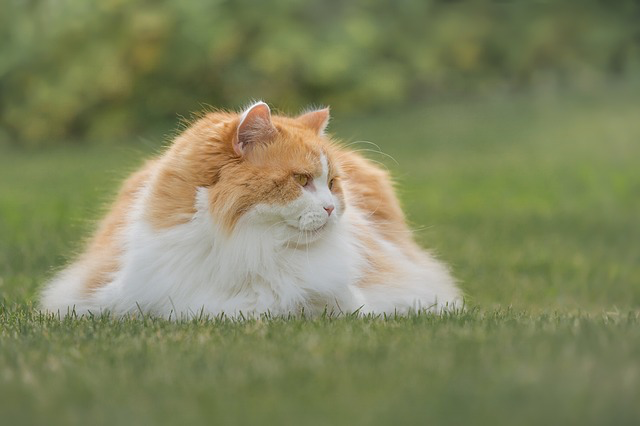

In [1]:
using Images, ImageView, ImageSegmentation
img = load("../sample-images/cat-3352842_640.jpg")

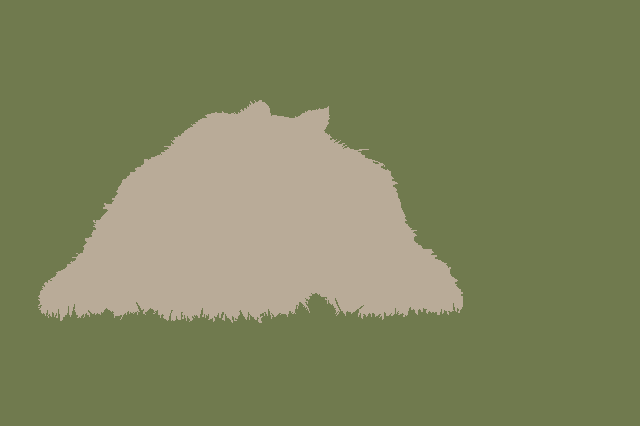

In [2]:
# Define the seeds
seeds = [
    (CartesianIndex(220,250), 1),
    (CartesianIndex(220,500), 2)
]

# Define segments using the seeds
segments = seeded_region_growing(img, seeds)

# Use a map to replace with the mean color for visualization
seg_img = map(i->segment_mean(segments,i), labels_map(segments))
seg_img

The downside of this approach is that it takes manual work. But it can be useful for prepping training data.

Next look at a more complex object, first the failure case for growing seeds algorithms:

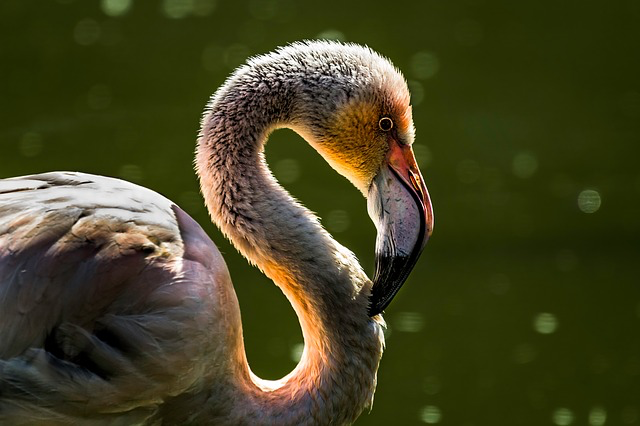

In [3]:
img = load("../sample-images/bird-3183441_640.jpg")
img

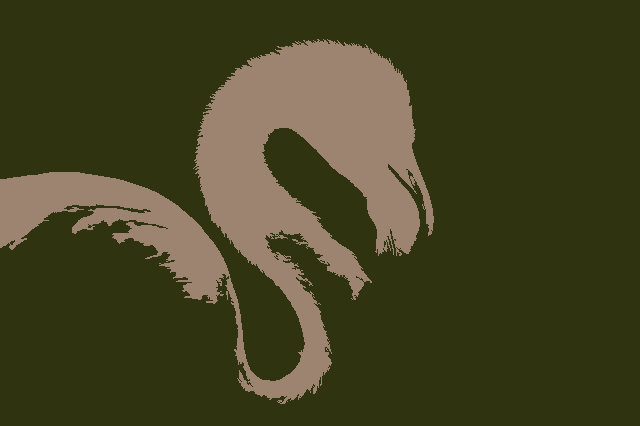

In [4]:
seeds = [
    (CartesianIndex(220,250), 1), # Object
    (CartesianIndex(220,500), 2) # Background    
]

segments = seeded_region_growing(img, seeds)
seg_img = map(i->segment_mean(segments,i), labels_map(segments))
seg_img

Not great, a result of the image having many colors, some of which are mistaken for background. To navigate, try setting mroe seeds.

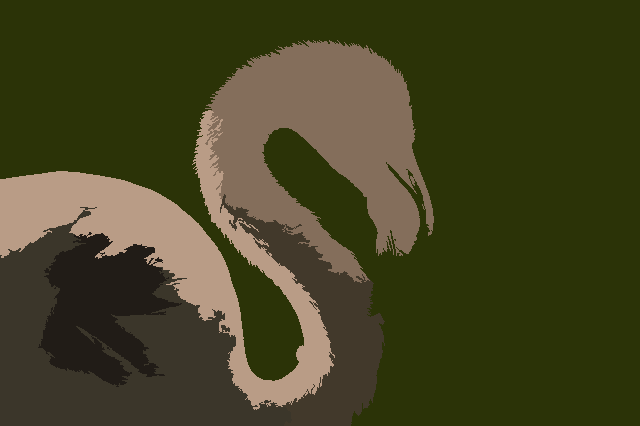

In [5]:
seeds = [
 (CartesianIndex(240,120), 1), 
 (CartesianIndex(295,70), 2),
 (CartesianIndex(319,40), 3),
 (CartesianIndex(90,300), 4),
 (CartesianIndex(295,325), 5),
 (CartesianIndex(76,135), 6) # background color
]

segments = seeded_region_growing(img, seeds)
seg_img = map(i->segment_mean(segments,i), labels_map(segments))
seg_img

## Unsupervised methods

Nicer to do this without defining labels

### Graph-based Approach - Felzenszwalb

This is a graph based approach with a linear execution time and few hyperparameters. Returning to the cat image,

In [6]:
img_cat = load("../sample-images/cat-3352842_640.jpg")

segments_1 = felzenszwalb(img, 75)
segments_2 = felzenszwalb(img, 75, 150)
segments_3 = felzenszwalb(img, 75, 350);

In [7]:
segment_to_image(segments) = map(i->segment_mean(segments, i), labels_map(segments));

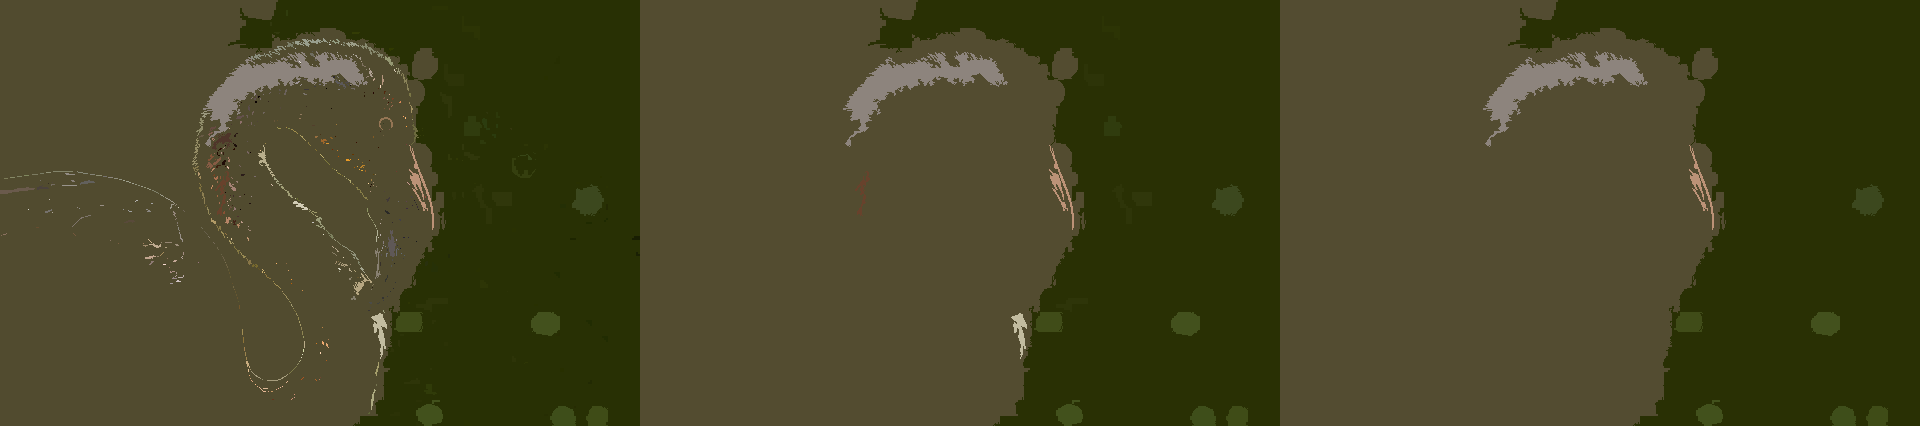

In [8]:
mosaicview(
    segment_to_image(segments_1),
    segment_to_image(segments_2),
    segment_to_image(segments_3),
    ncol=3
)

Alternatively, for the bird image

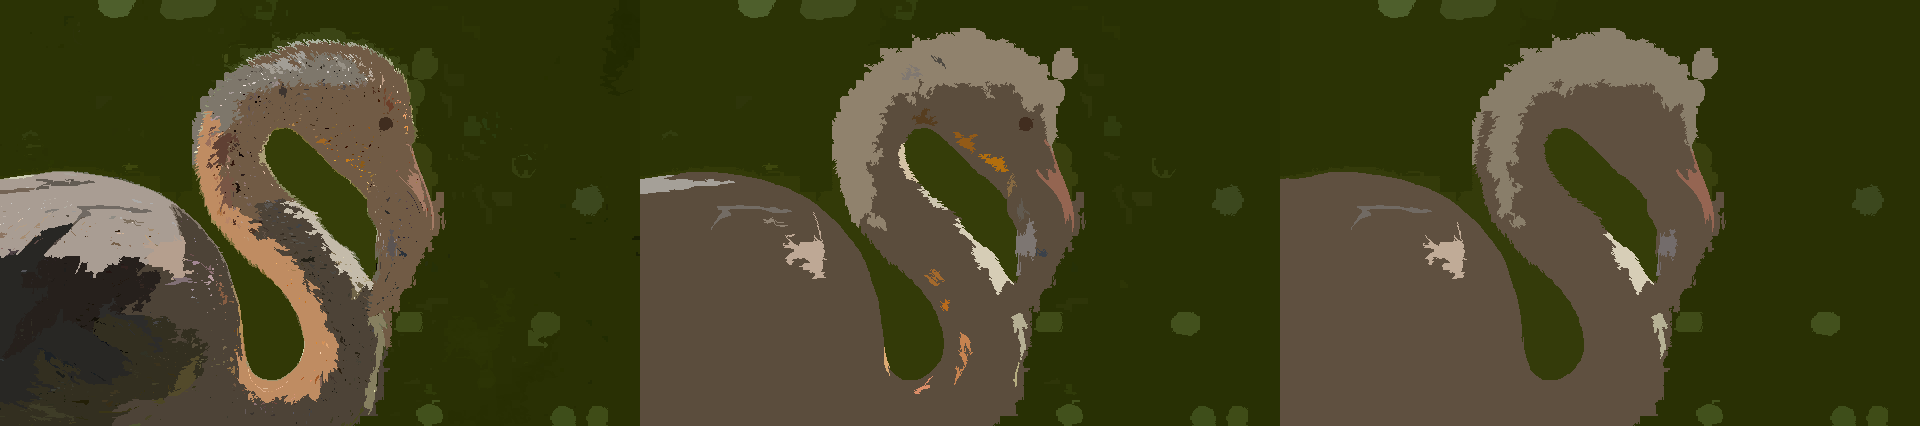

In [9]:
img_bird = load("../sample-images/bird-3183441_640.jpg")

# find segments
segments_1 = felzenszwalb(img, 10)
segments_2 = felzenszwalb(img, 30, 50)
segments_3 = felzenszwalb(img, 35, 300)

mosaicview(
    segment_to_image(segments_1),
    segment_to_image(segments_2),
    segment_to_image(segments_3),
    ncol=3
)

The first one separates well and keeps details. The second and third are simplified, but select the foreground well.

### Fast-Scanning Approach

Another unsupervised method. Scans pixels in the image, groups neighboring pixels within a threshold. We'll revisit the same two images with `fast_scanning` instead.

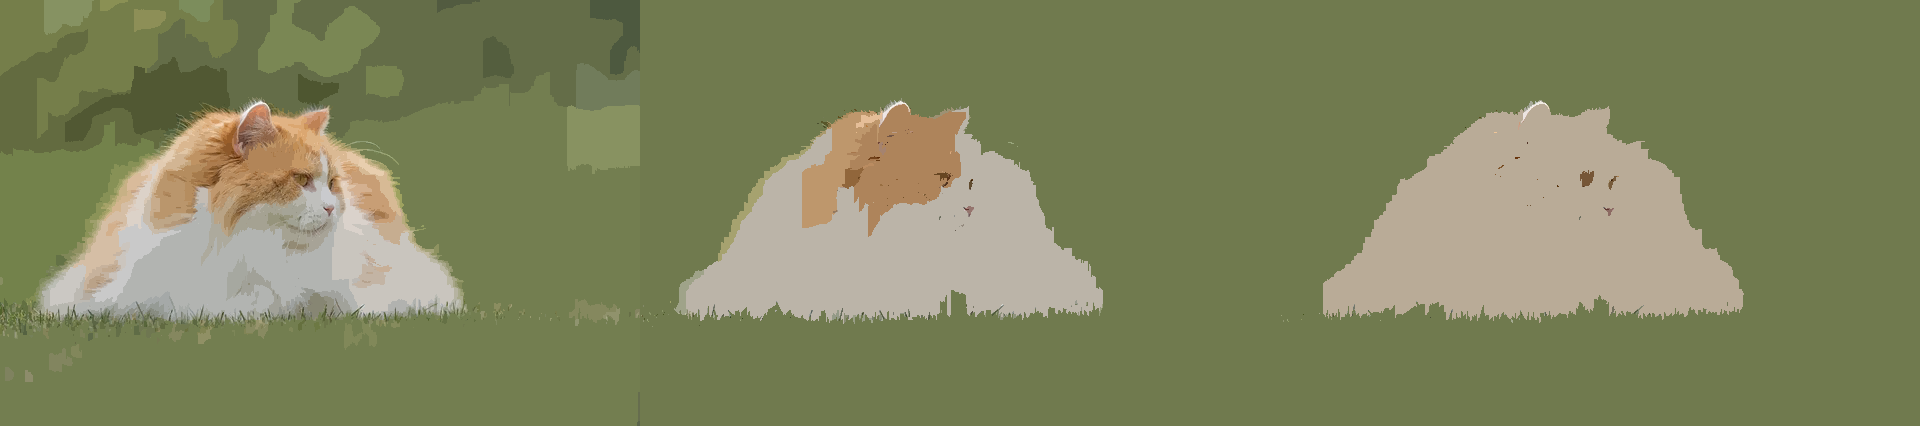

In [10]:
segments_1 = fast_scanning(img_cat, 0.05)
segments_2 = fast_scanning(img_cat, 0.15)
segments_3 = fast_scanning(img_cat, 0.2)
mosaicview(
    segment_to_image(segments_1),
    segment_to_image(segments_2),
    segment_to_image(segments_3),
    ncol=3    
)

This algorithm is notably quicker than the Felzenszwalb algorithm, and appears to have higher precision. The third image here oddly keeps some of the small segments. One option to solve this is to apply a deletion rule requiring a minimum segment size of 350 pixels

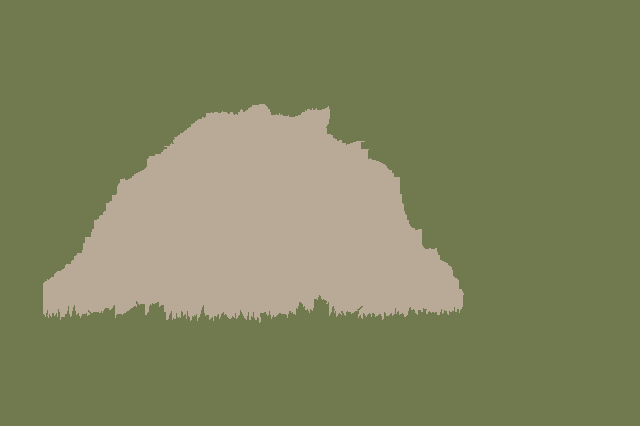

In [11]:
deletion_rule = i -> (segment_pixel_count(segments_3, i) < 350)
replacement_rule = (i, j) -> (-segment_pixel_count(segments_3, j))
segments_n = prune_segments(segments_3, deletion_rule, replacement_rule)
segment_to_image(segments_n)

Next try the bird image

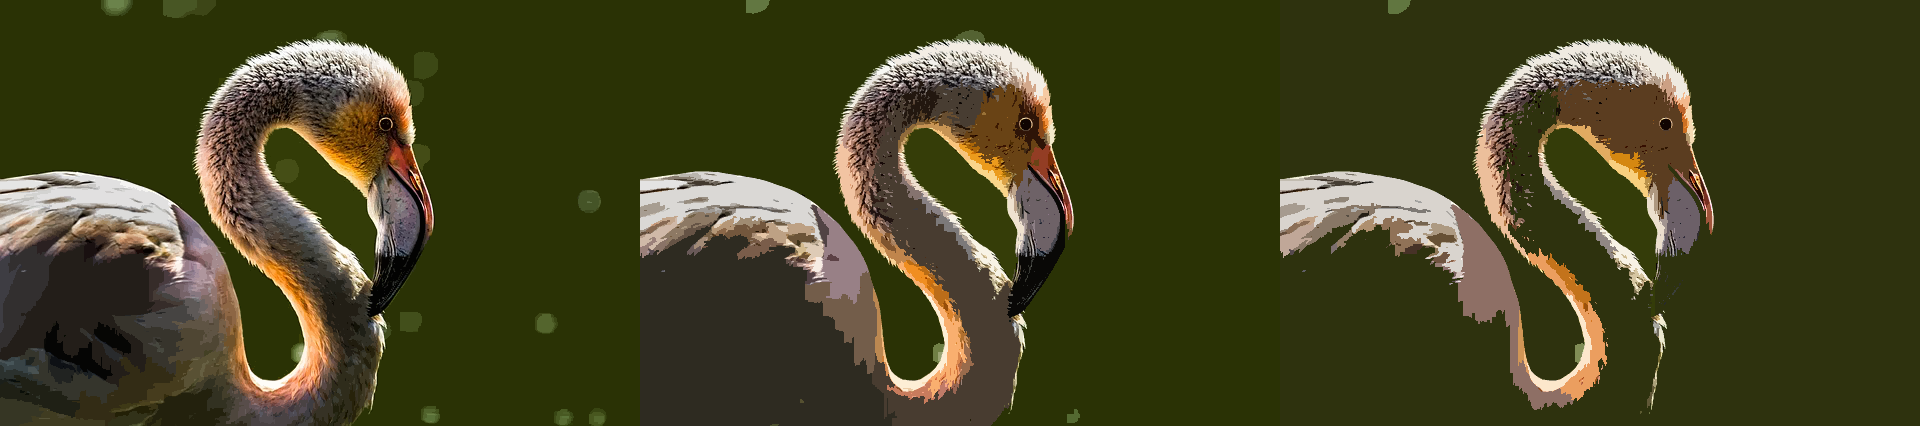

In [12]:
segments_1 = fast_scanning(img_bird, 0.05)
segments_2 = fast_scanning(img_bird, 0.15)
segments_3 = fast_scanning(img_bird, 0.2)
mosaicview(
    segment_to_image(segments_1),
    segment_to_image(segments_2),
    segment_to_image(segments_3),
    ncol=3    
)

This is not great, since there are many small details and the foreground color is similar to the background color. Pruning simplifies significantly, but still many clusters.

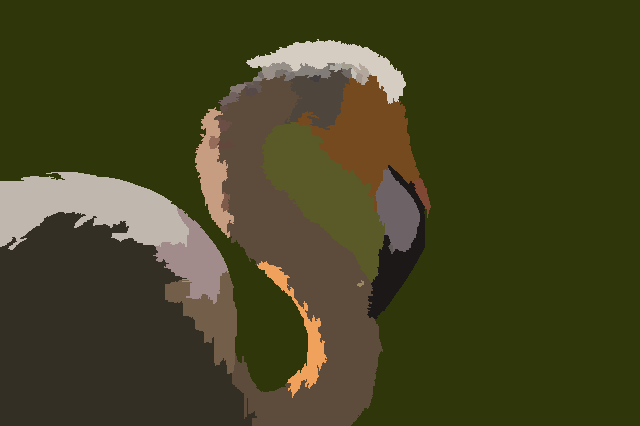

In [13]:
deletion_rule = i -> (segment_pixel_count(segments_2,i) < 750)
replacement_rule = (i,j) -> (-segment_pixel_count(segments_2, j))
segments_n = prune_segments(segments_2, deletion_rule, replacement_rule)

segment_to_image(segments_n)

### Helper Functions 

The output of the algorithm is a segmented image with a labels map (`{Int64, 2}`) and number of labels.

In [14]:
segments = felzenszwalb(img_bird, 75, 350)
segments

Segmented Image with:
  labels map: 426×640 Array{Int64,2}
  number of labels: 10

The `ImageSegmentation` library gives a bunch of helper functions to work with these:

- `labels_map`: An array of labels corresponding to every pixel of an image
- `segment_labels`: A list of all segment labels, either a number from 1 to N or a value you have set manually
- `segment_mean`: The mean intensity of the segment
- `segment_pixel_count`: The number of pixels from the image in the segment

